# Variational AutoEncoder

## Loading Modules

In [1]:
%matplotlib inline

import os

import numpy as np
import tensorflow as tf
import matplotlib as mpl

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import gridspec as grid

import priors
from autoencoder import Encoder, Decoder

from includes.config import Config
from includes.utils import load_data, Dataset

In [2]:
mpl.rc_file_defaults()

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
xav_init = tf.contrib.layers.xavier_initializer()

## Loading Data and Setting Parameters

In [5]:
datagroup = "mnist"
dataset = "binary"

In [6]:
config = Config(datagroup)

train_data, test_data = load_data(datagroup, dataset=dataset)

train_data = Dataset(train_data, batch_size=config.batch_size)
test_data = Dataset(test_data, batch_size=config.batch_size)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


## Visualizing the Data

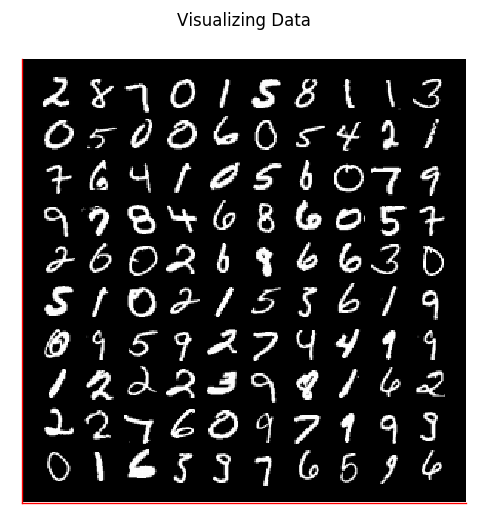

In [7]:
if datagroup == "spiral":
    plt.scatter(train_data.data[:, 0], train_data.data[:, 1], s=0.5)
elif datagroup == "mnist":
    images = train_data.data[np.random.choice(len(train_data), 100)]
    
    images = images.reshape((100, 28, 28))
    images = np.concatenate(images, axis=1)
    images = np.array([images[:, x:x+280] for x in range(0, 2800, 280)])
    images = np.concatenate(images, axis=0)
    images = np.concatenate(
        [np.zeros((280, 10)), images, np.zeros((280, 10))], axis=1
    )
    images = np.concatenate(
        [np.zeros((10, 300)), images, np.zeros((10, 300))], axis=0
    )

    plt.imshow(images, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.title("Visualizing Data")
plt.show()

## Defining the TensorFlow Graph

In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, (None, config.input_dim))
epsilon_binary = tf.placeholder(tf.float32, (None, 50, 2))
epsilon_normal = tf.placeholder(tf.float32, (None, 10))

temperature = tf.placeholder_with_default(1.0, shape=None, name="temperature")

encoder = Encoder("encoder", ["logits", "mean", "log_var"])
Z = encoder.build(
    [50 * 2, 10],                                             # Dimensions of Latent Variables
    [(1000, 500), (500, 200)],                                # Layer Sizes between Latent Variables
    [                                                         # Definition of Latent Variables
        (priors.DiscreteFactorial(50, 2), epsilon_binary),
        (priors.NormalFactorial(10), epsilon_normal)
    ],
    [["logits"], ["mean", "log_var"]],                        # Dependence of Latent Variables
    [{"temperature": temperature}, {}],                       # Additional parameters for reparametrization
    X                                                         # Initial Input Variable
)

decoder = Decoder("decoder", config.latent_type)
decoder.build(config.input_dim, config.decoder_layer_sizes, Z)

recon_X = decoder.output
if datagroup == "mnist":
    recon_X = tf.nn.sigmoid(recon_X)

latent_loss = encoder.kl_from_priors()

In [9]:
if datagroup == "mnist":
    recon_loss = tf.reduce_mean(tf.reduce_sum(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=X,
            logits=decoder.output
        ), axis=1
    ))
if datagroup == "spiral":
    recon_loss = tf.reduce_mean(tf.reduce_sum(
        tf.square(
            decoder.output - X
        ), axis=1
    ))

    
loss = recon_loss + latent_loss

In [10]:
learning_rate = tf.train.exponential_decay(
    learning_rate=config.learning_rate,
    global_step=0,
    decay_steps=train_data.epoch_len * config.decay_steps,
    decay_rate=config.decay_rate
)

train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

## Defining functions for Plotting

### Reconstruction Plot

In [11]:
def regeneration_plot(epoch, datagroup, dataset):
    path = "plots/regenerated/%s/%s" % (datagroup, dataset)
    
    if not os.path.exists(path):
        os.makedirs(path)

    gs = grid.GridSpec(1, 2) 

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
        
    if datagroup == "mnist":
        def reshape(images):
            images = images.reshape((100, 28, 28))
            images = np.concatenate(images, axis=1)
            images = np.array([images[:, x:x+280] for x in range(0, 2800, 280)])
            images = np.concatenate(images, axis=0)
            images = np.concatenate(
                [np.zeros((280, 10)), images, np.zeros((280, 10))], axis=1
            )
            images = np.concatenate(
                [np.zeros((10, 300)), images, np.zeros((10, 300))], axis=0
            )

            return images

        lv_binary, lv_normal = encoder.sample_reparametrization_variables(100)
        
        orig_X = test_data.data[:100]
        recn_X = sess.run(
            recon_X,
            feed_dict={
                X: orig_X,
                epsilon_binary: lv_binary,
                epsilon_normal: lv_normal
            }
        )

        ax1.imshow(reshape(orig_X), cmap="Greys_r")
        ax2.imshow(reshape(recn_X), cmap="Greys_r")
        
        ax2.spines['left'].set_visible(False)
        
    elif datagroup == "spiral":
        recn_X = sess.run(
            recon_X,
            feed_dict={
                X: test_data.data,
                epsilon: np.random.randn(len(test_data.data), config.latent_dim)
            }
        )
        
        ax1.scatter(test_data.data[:, 0], test_data.data[:, 1], s=0.5)
        ax2.scatter(recn_X[:, 0], recn_X[:, 1], s=0.5)
        
    else:
        raise NotImplementedError
        
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2.spines['bottom'].set_visible(False)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.savefig(path + "/%s.png" % str(epoch), transparent=True)

### Sampling Plot

In [12]:
def sample_plot(epoch, dataset="mnist"):
    if not os.path.exists("plots/sampled/" + dataset):
        os.makedirs("plots/sampled/" + dataset)
    
    gs = grid.GridSpec(1, 2)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    mus, sigmas = sess.run([prior_means, prior_vars], feed_dict={})
    
    sigmas = np.sqrt(sigmas)
    
    if dataset == "mnist":
        sample_Z = list()
        decoded_X = list()
        for k in range(0, conf.n_clusters):
            s_Z = mus[k] + sigmas[k] * np.random.randn(1000, conf.latent_dim)
            sample_Z.append(s_Z)

            decoded_X.append(sess.run(
                decoded_X_mean,
                feed_dict={
                    Z: s_Z
                }
            ))

        sample_Z = np.concatenate(sample_Z, axis=0)
        if conf.latent_dim > 2:
            sample_Z = TSNE(n_components=2).fit_transform(sample_Z)
        
        sample_Z = sample_Z.reshape((conf.n_clusters, sample_Z.shape[0] / conf.n_clusters, 2))

        image = (
            1 - np.concatenate(
                np.concatenate(
                    np.array(decoded_X)[:, :10].reshape((10, 10, 28, 28)),
                    axis=1
                ), 
                axis=1
            )
        )

        ax1.imshow(image, cmap="Greys")

        for k in range(0, conf.n_clusters):
            ax2.scatter(sample_Z[k][:, 0], sample_Z[k][:, 1], s=0.5)
        
    elif dataset == "spiral":
        eps = np.random.randn(conf.n_clusters, 1000, conf.latent_dim)
        
        sample_Z = np.concatenate([eps[k] * sigmas[k] + mus[k] for k in range(0, conf.n_clusters)])
        
        decoded_X = [
            sess.run(
                decoded_exp_X_mean,
                feed_dict={
                    Z: sample_Z[1000*k:1000*(k + 1)]
                }
            ) for k in range(0, conf.n_clusters)
        ]
        
        if conf.latent_dim > 2:
            sample_Z = TSNE(n_components=2).fit_transform(sample_Z)

        for k in range(0, conf.n_clusters):
            ax1.scatter(decoded_X[k][:, 0], decoded_X[k][:, 1], s=0.5)
            ax2.scatter(sample_Z[1000*k:1000*(k+1), 0], sample_Z[1000*k:1000*(k+1), 1], s=0.5)

    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2.spines['bottom'].set_visible(False)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.savefig("plots/sampled/" + dataset + "/" + str(epoch) + ".png", transparent=True)

## Starting the Session

In [13]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

## Training for VAE parameters

In [14]:
with tqdm(range(500), postfix={"loss": "inf"}) as bar:
    for epoch in bar:
        if epoch % 5 == 0:
            regeneration_plot(epoch, datagroup, dataset)
        
        J = 0.0
        for batch in train_data.get_batches():
            lv_binary, lv_normal = encoder.sample_reparametrization_variables(len(batch))
            out = sess.run(
                [loss, recon_loss, latent_loss, train_step],
                feed_dict={
                    X: batch,
                    epsilon_binary: lv_binary,
                    epsilon_normal: lv_normal,
                    temperature: 0.1
                }
            )
            J += out[0] / train_data.epoch_len

        bar.set_postfix({"loss": "%.4f" % J})

 36%|███▌      | 181/500 [16:22<33:07,  6.23s/it, loss=89.4140]


KeyboardInterrupt: 